In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

tf.disable_v2_behavior()

%matplotlib inline
np.random.seed(1)


Instructions for updating:
non-resource variables are not supported in the long term


### 手语数据集

- 训练数据集：1080张图 (64 * 64)，它们表示0到5的数字。
- 测试数据集：120张图 (64 * 64)，它们表示0到5的数字。

本例的数据集中只有5个手势，完整的数据集中有很多手势。

下面给出了每一个数字所对应的一个手势图，这还是没有缩放成64*64像素的原图。

<img src="images/hands.png" style="width:800px;height:350px;">

### 加载数据集

In [4]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# 扁平化
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T

# 简单的归一化
X_train = X_train_flatten / 255.  # shape=(12288, 1080)
X_test = X_test_flatten / 255.  # shape=(12288, 120)

# convert to one_hot_encoding
Y_train = convert_to_one_hot(Y_train_orig, 6)  # shape=(6, 1080)
Y_test = convert_to_one_hot(Y_test_orig, 6)  # shape=(6, 120)


任务：构建一个人工智能程序来学习上面的数据，让这个AI程序能够很准确地识别0到5的手语。

模型结构：LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX。

### 创建占位符

In [5]:
def create_placeholders(n_x, n_y):

    X = tf.placeholder(tf.float32, [n_x, None], name="X")
    Y = tf.placeholder(tf.float32, [n_y, None], name="Y")

    return X, Y


### 初始化参数

In [6]:
def initialize_parameters():

    # 将tensorflow中的随机数种子设为1，这样可以确保我们每次执行代码时随机数都是一样的
    tf.set_random_seed(1)

    W1 = tf.get_variable(
        "W1", [25, 12288], initializer=tf.truncated_normal_initializer(stddev=0.1, seed=1))
    b1 = tf.get_variable("b1", [25, 1], initializer=tf.zeros_initializer())

    W2 = tf.get_variable(
        "W2", [12, 25], initializer=tf.truncated_normal_initializer(stddev=0.1, seed=1))
    b2 = tf.get_variable("b2", [12, 1], initializer=tf.zeros_initializer())

    W3 = tf.get_variable(
        "W3", [6, 12], initializer=tf.truncated_normal_initializer(stddev=0.1, seed=1))
    b3 = tf.get_variable("b3", [6, 1], initializer=tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}

    return parameters


### 前向传播

In [7]:
def forward_propagation(X, parameters):

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)

    return Z3


### 计算成本

In [8]:
def compute_cost(Z3, Y):

    # transpose表示装置操作
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits=logits, labels=labels))

    return cost


### 构建完整模型

In [9]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.0001,
          num_epochs=100, minibatch_size=32, print_cost=True):

    tf.set_random_seed(1)
    seed = 3
    (n_x, m) = X_train.shape  # n_x:特征数量, m:训练集中的样本数
    n_y = Y_train.shape[0]
    costs = []

    X, Y = create_placeholders(n_x, n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    optimizer = tf.train.AdamOptimizer(
        learning_rate=learning_rate).minimize(cost)
    init = tf.global_variables_initializer()

    with tf.Session() as sess:
        sess.run(init)

        for epoch in range(num_epochs):
            epoch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(
                X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _, minibatch_cost = sess.run([optimizer, cost], feed_dict={
                                             X: minibatch_X, Y: minibatch_Y})
                epoch_cost += minibatch_cost / num_minibatches

            if print_cost == True and epoch % 100 == 0:
                print("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)

        # 画出cost成本的走势图
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # 从计算图中获取训练好了的参数, 后面就可以用这些参数来识别手语了
        parameters = sess.run(parameters)
        print("Parameters have been trained!")

        # 分别计算一下在训练集和测试集上面的预测精准度
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))

        return parameters


运行下面的代码来训练模型。

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cost after epoch 0: 1.863846


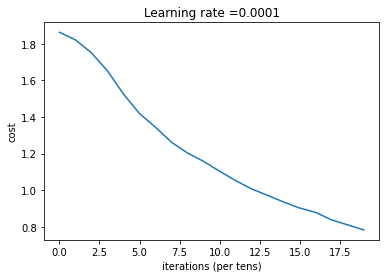

Parameters have been trained!
Train Accuracy: 0.7453704
Test Accuracy: 0.675


In [10]:
parameters = model(X_train, Y_train, X_test, Y_test)

### 识别你的手势

模型我们已经训练好了，用下面的代码你可以用自己的手测试一下。你做个0到5的手势，然后用手机拍下来，将图片的名字改为thumbs_up.jpg，然后用它替换掉本文档同目录下面的images文件夹里面的thumbs_up.jpg。

Your algorithm predicts: y = 3


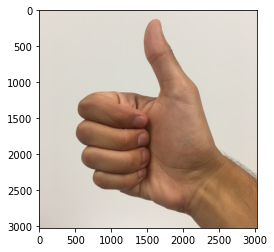

In [12]:
import skimage.transform as tsf
from PIL import Image

my_image = "thumbs_up.jpg"

fname = "images/" + my_image
image = np.array(plt.imread(fname))
my_image = tsf.resize(image, (64, 64), mode='reflect').reshape(
    (1, 64 * 64 * 3)).T
my_image_prediction = predict(my_image, parameters)

plt.imshow(image)
print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))
